In [83]:
%matplotlib inline
import matplotlib.pylab
import os
#import mne
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
from pylab import savefig

import pylab as pl
from IPython.display import display

import glob
import copy

pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import seaborn as sns
sns.set_context(rc={"figure.figsize": (10,10),'font.size': 16})

height has been deprecated.



### Define subject groups

In [84]:
pfw = ['FACT_106', 'FACT_108', 'FACT_109', 'FACT_110', 'FACT_115',
'FACT_116', 'FACT_120', 'FACT_123', 'FACT_128', 'FACT_141', 'FACT_142', 'FACT_151', 'FACT_159', 'FACT_160',
'FACT_165', 'FACT_166', 'FACT_167', 'FACT_172', 'FACT_176', 'FACT_177', 'FACT_179', 'FACT_182']
#pfw = high

pws = ['FACT_113', 'FACT_114', 'FACT_129', 'FACT_131', 'FACT_134', 'FACT_135', 'FACT_137',
'FACT_138', 'FACT_143', 'FACT_145', 'FACT_147', 'FACT_148', 'FACT_149', 'FACT_154', 'FACT_156',
'FACT_157', 'FACT_162', 'FACT_174', 'FACT_178']
#pws = low

#pws_bin = np.zeros(39)
#pws_bin[pws] = 1

### define directory paths

In [85]:
restdir = '/Users/julialeonard/om/resting_output/'
aparc_results = 'parcellations/aparc/'

### Connect to openmind via SSHFS:

In [ ]:
#if ~os.path.isdir(restdir):
#    os.system("sshfs ~/om jlnrd@openmind7.mit.edu:/ -o defer_permissions")

### load freesurfer LUT table

In [86]:
fsLUT_file = '/Users/julialeonard/om/resting_output/FreeSurferColorLUT.txt'
fsLUT = pd.read_table(fsLUT_file,skiprows=4)

IOError: File /Users/julialeonard/om/resting_output/FreeSurferColorLUT.txt does not exist

### Get ROI names:

In [32]:
for sx, s in enumerate(sorted(os.listdir(restdir))):
    #if len(roi_list > 0):
    if s[0] == 'F' and s[1]=='A': # S25 has a weird lh-frontalpole - ends up nan after corrcoef & fisher

        subdir = os.path.join(restdir,s,'resting')

        # ROI names
        sumstats_file = os.path.join(subdir,aparc_results,'rest_01_summary.stats')
        sumstats = pd.read_csv(sumstats_file,header=None,skiprows=53)
        roi = []
        roi_list = []
        for r in range(0,sumstats.shape[0]):
            roi = sumstats[0][r][30:64]
            roi = roi.strip()
            roi_list.append(roi)

In [81]:
roi_list

['Left-Cerebellum-Cortex',
 'Left-Thalamus-Proper',
 'Left-Caudate',
 'Left-Putamen',
 'Left-Pallidum',
 'Left-Hippocampus',
 'Left-Amygdala',
 'Left-Accumbens-area',
 'Right-Cerebellum-Cortex',
 'Right-Thalamus-Proper',
 'Right-Caudate',
 'Right-Putamen',
 'Right-Pallidum',
 'Right-Hippocampus',
 'Right-Amygdala',
 'Right-Accumbens-area',
 'ctx-lh-bankssts',
 'ctx-lh-caudalanteriorcingulate',
 'ctx-lh-caudalmiddlefrontal',
 'ctx-lh-cuneus',
 'ctx-lh-entorhinal',
 'ctx-lh-fusiform',
 'ctx-lh-inferiorparietal',
 'ctx-lh-inferiortemporal',
 'ctx-lh-isthmuscingulate',
 'ctx-lh-lateraloccipital',
 'ctx-lh-lateralorbitofrontal',
 'ctx-lh-lingual',
 'ctx-lh-medialorbitofrontal',
 'ctx-lh-middletemporal',
 'ctx-lh-parahippocampal',
 'ctx-lh-paracentral',
 'ctx-lh-parsopercularis',
 'ctx-lh-parsorbitalis',
 'ctx-lh-parstriangularis',
 'ctx-lh-pericalcarine',
 'ctx-lh-postcentral',
 'ctx-lh-posteriorcingulate',
 'ctx-lh-precentral',
 'ctx-lh-precuneus',
 'ctx-lh-rostralanteriorcingulate',
 'ctx

In [33]:
names = []
for rn in range(0,len(roi_list)):#rs_timecorr.shape[1]):
    names.append(roi_list[rn])

### Reorder into structurally similar groups:¶


In [34]:
# want the mne circle plot to have anterior on left, posterior on right, with rh on top and lh on bottom
# start with posterior rh

anat_order = ['Right-Cerebellum-Cortex',\
              'Right-Thalamus-Proper','Right-Pallidum','Right-Putamen','Right-Caudate', 'Right-Hippocampus','Right-Amygdala','Right-Accumbens-area',\
              'wm-rh-lateraloccipital','wm-rh-lingual','wm-rh-cuneus','wm-rh-pericalcarine',\
              'wm-rh-precuneus','wm-rh-superiorparietal','wm-rh-inferiorparietal','wm-rh-supramarginal',\
              'wm-rh-parahippocampal','wm-rh-entorhinal','wm-rh-fusiform','wm-rh-inferiortemporal','wm-rh-temporalpole','wm-rh-middletemporal','wm-rh-transversetemporal','wm-rh-bankssts','wm-rh-superiortemporal',\
              'wm-rh-insula',\
              'wm-rh-posteriorcingulate','wm-rh-isthmuscingulate','wm-rh-caudalanteriorcingulate','wm-rh-rostralanteriorcingulate',\
              'wm-rh-paracentral','wm-rh-postcentral','wm-rh-precentral', \
              'wm-rh-parsopercularis','wm-rh-parstriangularis','wm-rh-parsorbitalis','wm-rh-lateralorbitofrontal','wm-rh-caudalmiddlefrontal','wm-rh-medialorbitofrontal','wm-rh-rostralmiddlefrontal','wm-rh-superiorfrontal','wm-rh-frontalpole',\
              'wm-lh-frontalpole','wm-lh-superiorfrontal', 'wm-lh-rostralmiddlefrontal','wm-lh-medialorbitofrontal','wm-lh-caudalmiddlefrontal', \
              'wm-lh-lateralorbitofrontal','wm-lh-parsorbitalis','wm-lh-parstriangularis','wm-lh-parsopercularis',\
              'wm-lh-precentral','wm-lh-postcentral','wm-lh-paracentral','wm-lh-rostralanteriorcingulate', \
              'wm-lh-caudalanteriorcingulate','wm-lh-posteriorcingulate','wm-lh-isthmuscingulate','wm-lh-insula',\
              'wm-lh-superiortemporal','wm-lh-bankssts','wm-lh-transversetemporal','wm-lh-middletemporal', \
              'wm-lh-temporalpole','wm-lh-inferiortemporal','wm-lh-fusiform','wm-lh-entorhinal','wm-lh-parahippocampal',\
              'wm-lh-supramarginal',\
              'wm-lh-inferiorparietal','wm-lh-superiorparietal','wm-lh-precuneus','wm-lh-pericalcarine','wm-lh-cuneus',\
              'wm-lh-lingual','wm-lh-lateraloccipital','Left-Accumbens-area','Left-Amygdala', \
              'Left-Hippocampus','Left-Caudate','Left-Putamen','Left-Pallidum','Left-Thalamus-Proper', \
              'Left-Cerebellum-Cortex'] 
'''order:
[brainstem, right_cerebellum, right_subcort, right_cortex, right_occipital, right_parietal, \
right_temporal, right_insula, right_cingulate,right_frontal,right_central_frontal,right_medinf_frontal, \
right_suplat_frontal,left_suplat_frontal,left_medinf_frontal,left_central_frontal,left_frontal, \
left_cingulate,left_insula,left_suplat_temporal,left_medinf_temporal,left_temporal,left_parietal,left_occipital, \
left_cortex,left_subcort, left_cerebellum])
'''
anat_order.reverse()

anat_order = [n.replace('wm-','ctx-') for n in anat_order]

anat_num_order = np.zeros((len(anat_order),1))
for ax,anat in enumerate(anat_order):
    anat_num_order[ax] = int(list(names).index(anat))



In [35]:
roi_list_sh = []
for r in anat_order:#roi_list:
    if r[0:4] == 'ctx-':
        roi_list_sh.append(r[4:])
    elif r[-7:]=='-Cortex':
        roi_list_sh.append(r[:-7])
    elif r[-7:]=='-Proper':
        roi_list_sh.append(r[:-7])
    elif r[-5:]=='-area':
        roi_list_sh.append(r[:-5])
    else:
        roi_list_sh.append(r)
#print roi_list_sh


### Extract resting state timecourse data

For each subject, run cross-correlations across all ROIs and save as ROIxROI timecorr matrix:

In [36]:
anat_num_order[:5]

array([[ 0.],
       [ 1.],
       [ 4.],
       [ 3.],
       [ 2.]])

In [69]:
pws_i = 0
pfs_i = 0
rs_timecorr_pws = []
rs_timecorr_pfs = []
pws_subs = []
pfs_subs = []

n_subs = 0
rs_timecorr_allsubs = []
all_subs = []

for sx, s in enumerate(sorted(os.listdir(restdir))):
    if s[0] == 'F' and s[1] =='A' : 
        
        subdir = os.path.join(restdir,s,'resting')

        # timecourse data
        avgwf_file = os.path.join(subdir,aparc_results,'rest_01_avgwf.txt')
        avgwf = np.loadtxt(avgwf_file)
        rs_timecorr = np.zeros((avgwf.shape[1],avgwf.shape[1]))
        # for roi_reorder, see below in ROI names section:
        for ix, r in enumerate(anat_num_order):#range(0,avgwf.shape[1]):
            r = int(r)
            for inx, rn in enumerate(anat_num_order):
                rn = int(rn)
                #rs_timecorr[r,rn] = np.correlate(avgwf[:,r],avgwf[:,rn])
                # arctanh = Fisher transform:
                rs_timecorr[ix,inx] = np.arctanh(np.corrcoef(avgwf[:,r],avgwf[:,rn])[0,1]) 
                
                # changed 3/11/16 - shouldn't this be by anat_num_order, not by ix?
                #rs_timecorr[r,rn] = np.arctanh(np.corrcoef(avgwf[:,r],avgwf[:,rn])[0,1])
                # 3/12: ^^ NO. we want to reorder the data
                
        #timefile = os.path.join(subdir,aparc_results,'time_corr.txt')
        #np.savetxt(timefile, rs_timecorr)
        
        if n_subs == 0:
            rs_timecorr_allsubs = rs_timecorr
            rs_timeseries = avgwf
        else:
            rs_timecorr_allsubs = np.vstack((rs_timecorr_allsubs, rs_timecorr))
            rs_timeseries = np.vstack((rs_timeseries,avgwf))
        all_subs.append(s)
        n_subs += 1
        #rs_timecorr_allsubs = np.vstack((rs_timecorr_allsubs, rs_timecorr))

        
        # add to group-level data
        #a = np.array(s[5:8])
        #if a.astype(int) - 1 in pws:
        if s in pws:
            if pws_i == 0:
                rs_timecorr_pws = rs_timecorr
            else:
                rs_timecorr_pws = np.vstack((rs_timecorr_pws,rs_timecorr))
            pws_i += 1
            pws_subs.append(s)
        if s in pfs:
            if pfs_i == 0:
                rs_timecorr_pfs = rs_timecorr
            else:
                rs_timecorr_pfs = np.vstack((rs_timecorr_pfs,rs_timecorr))
            pfs_i += 1
            pfs_subs.append(s)

# reshape to 3D (subj x ROI x ROI)
rs_timeseries = rs_timeseries.reshape((n_subs,-1,84))
rs_timecorr_allsubs = rs_timecorr_allsubs.reshape((n_subs,-1,84))
rs_timecorr_pws = rs_timecorr_pws.reshape((pws_i,-1,84))
rs_timecorr_pfs = rs_timecorr_pfs.reshape((pfs_i,-1,84))

In [72]:
#check data!
pfs_subs

['FACT_106',
 'FACT_108',
 'FACT_109',
 'FACT_110',
 'FACT_115',
 'FACT_116',
 'FACT_120',
 'FACT_123',
 'FACT_128',
 'FACT_141',
 'FACT_142',
 'FACT_151',
 'FACT_159',
 'FACT_160',
 'FACT_165',
 'FACT_166',
 'FACT_167',
 'FACT_172',
 'FACT_176',
 'FACT_177',
 'FACT_179',
 'FACT_182']

TypeError: list indices must be integers, not str

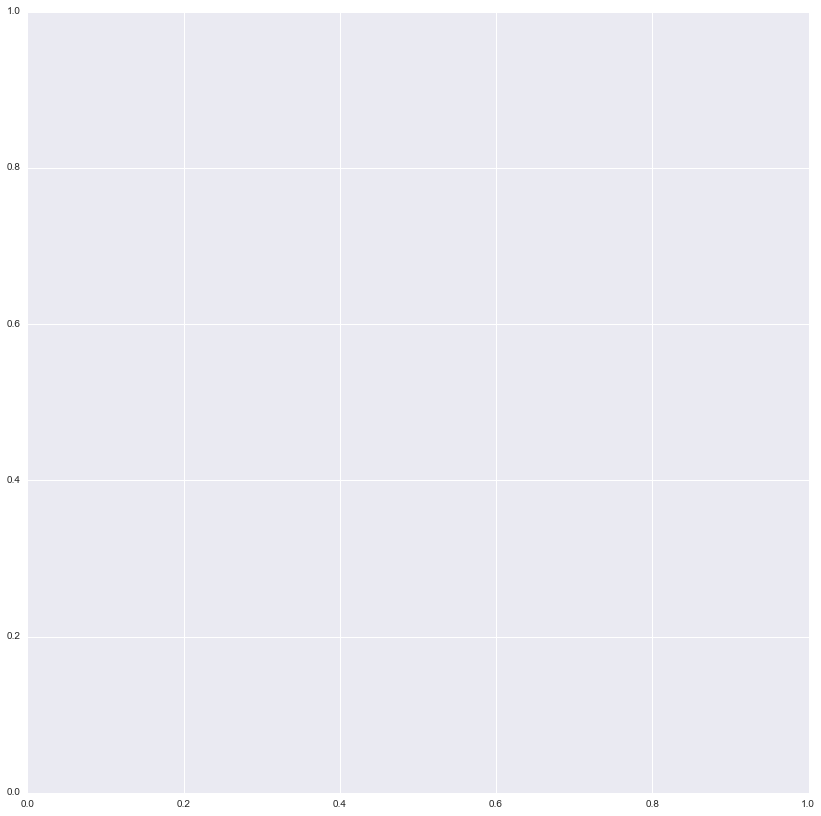

In [82]:
#print rs_timecorr_allsubs[s,38:44,38:44]

sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
f, ax = plt.subplots(figsize=(14,14))
ax.set_title('subject %s correlations'%(all_subs[s]))
sns.color_palette("RdBu_r")
sns.corrplot(rs_timecorr_allsubs[s,:,:], annot=False, sig_stars=False,
             diag_names=False, ax=ax, names = roi_list_sh)
f.tight_layout()


In [74]:
print rs_timecorr_allsubs.shape
print rs_timecorr_pfs.shape
print rs_timecorr_pws.shape

(62, 84, 84)
(22, 84, 84)
(19, 84, 84)


### Get the mean value across subjects (within each group):¶

In [77]:
rs_mean_pws = np.mean(rs_timecorr_pws,axis=0)
rs_mean_pfs = np.mean(rs_timecorr_pfs,axis=0)
print rs_mean_pfs.shape
print rs_mean_pws.shape

(84, 84)
(84, 84)


In [79]:
rs_mean_pfs[38:44,38:44]

array([[        inf,  0.33749137,  0.49143743,  0.44839792,  0.43358904,
         0.35137671],
       [ 0.33749137,         inf,  0.66236028,  0.33541636,  0.29995851,
         0.5517171 ],
       [ 0.49143743,  0.66236028,         inf,  0.31881147,  0.25517339,
         1.032874  ],
       [ 0.44839792,  0.33541636,  0.31881147,         inf,  0.76409454,
         0.23561752],
       [ 0.43358904,  0.29995851,  0.25517339,  0.76409454,         inf,
         0.30965364],
       [ 0.35137671,  0.5517171 ,  1.032874  ,  0.23561752,  0.30965364,
                inf]])

In [78]:
rs_mean_pfs[38:44,38:44]

array([[        inf,  0.33749137,  0.49143743,  0.44839792,  0.43358904,
         0.35137671],
       [ 0.33749137,         inf,  0.66236028,  0.33541636,  0.29995851,
         0.5517171 ],
       [ 0.49143743,  0.66236028,         inf,  0.31881147,  0.25517339,
         1.032874  ],
       [ 0.44839792,  0.33541636,  0.31881147,         inf,  0.76409454,
         0.23561752],
       [ 0.43358904,  0.29995851,  0.25517339,  0.76409454,         inf,
         0.30965364],
       [ 0.35137671,  0.5517171 ,  1.032874  ,  0.23561752,  0.30965364,
                inf]])